Problem B — Why Did This User Cancel Their Subscription?
Overview
You work for a subscription-based app. Users are cancelling. But knowing that they cancelled isn't enough — the product team needs to know why.

Every churned user left for one of four reasons. Your task: Given a user's behavior, account, and device data, predict the reason they cancelled.

Target Variable
Column	Type	Values
churn_reason	string	price_sensitive, bad_experience, found_alternative, lost_interest
price_sensitive — user left primarily due to cost (price increase, couldn't justify the spend, found it too expensive)
bad_experience — user left due to app quality issues (crashes, bugs, poor support, slow performance)
found_alternative — user switched to a competing app that better met their needs
lost_interest — user gradually disengaged; no specific trigger, just stopped caring
Why this is hard: These reasons overlap. A user on a budget phone with frequent crashes who also installed a competitor — is that bad_experience or found_alternative? A user who experienced a price increase and also stopped logging in — is that price_sensitive or lost_interest? The boundaries are fuzzy by design. This is what makes real-world multiclass problems difficult.

Evaluation Metric
Macro F1 Score

Macro F1 averages the F1 score across all four classes equally. Your model must perform reasonably on every class — not just the most common one. Predicting only the majority class will get a very low score.

Feature Schema
Your training data, dummy test data, and final test data will all follow this exact schema. Every column name, data type, and allowed value is defined below. There are no other columns.

#	Column Name	Type	Allowed Values / Range	Description
1	id	integer	1+	Unique row identifier
2	user_age_group	string	teen, young_adult, adult, middle_aged, senior	User's age bracket
3	gender	string	male, female, non_binary, undisclosed	User's gender
4	subscription_plan	string	free_trial, basic, standard, premium, student	Plan at time of cancellation
5	monthly_price_inr	float	0.0–999.0	Monthly subscription cost in INR (0 for free trial)
6	subscription_duration_days	integer	1–1825	How long the user was subscribed before cancelling (up to 5 years)
7	payment_method	string	upi, credit_card, debit_card, net_banking, wallet	Payment method used
8	num_payment_failures_90d	integer	0–15	Number of failed payment attempts in last 90 days
9	days_since_last_login	integer	0–365	Days between last login and cancellation date
10	avg_session_duration_min	float	0.0–180.0	Average session length in minutes
11	sessions_per_week	float	0.0–50.0	Average sessions per week over subscription period
12	session_trend_30d	string	increasing, stable, declining, inactive	Trend in session activity over last 30 days
13	features_used_pct	float	0.0–100.0	Percentage of app features the user has ever used
14	num_support_tickets_90d	integer	0–20	Support tickets raised in last 90 days
15	avg_ticket_resolution_hrs	float	0.0–720.0	Average time to resolve a support ticket in hours (up to 30 days; 0.0 if no tickets)
16	unresolved_tickets	integer	0–10	Number of support tickets still open at cancellation
17	app_crash_count_30d	integer	0–50	Number of app crashes in the last 30 days
18	rating_given	float	0.0–5.0	Rating user gave the app on the store (0.0 = never rated)
19	num_referrals_made	integer	0–20	Number of friends the user referred to the app
20	competitor_app_installed	boolean	true, false	Whether a competing app was detected on the user's device
21	price_increase_experienced	boolean	true, false	Whether the user's price was increased during subscription
22	used_discount_code	boolean	true, false	Whether the user originally signed up using a discount or promo
23	device_type	string	budget_android, mid_android, flagship_android, iphone, ipad, desktop, multi_device	User's primary device
24	os_version_age_months	integer	0–60	How old the user's OS version is in months
25	internet_speed_category	string	slow_2g, moderate_3g, fast_4g, ultra_5g, broadband	User's typical internet speed
26	onboarding_completed	boolean	true, false	Whether the user completed the app's onboarding/tutorial
27	content_category_preference	string	entertainment, education, productivity, fitness, news, social, mixed	User's primary content category
28	days_since_last_feature_use	integer	0–365	Days since user last used a core app feature
29	notification_opt_in	boolean	true, false	Whether the user has push notifications enabled
Total: 28 features + 1 id + 1 target = 30 columns in training data, 29 columns in test data (no target)

Class Descriptions and Signal Patterns
These descriptions are hints, not rules. The real patterns are in the data.

price_sensitive — These users cared about cost. Look for signals around pricing, payment failures, discount usage, and subscription plan changes. But not every user who experienced a price increase left because of price — some had other reasons too.

bad_experience — These users had a frustrating time with the app. Look for signals around crashes, support tickets, unresolved issues, and device/connectivity problems. But some users with crashes left for other reasons (found a competitor that works better, or just lost interest entirely).

found_alternative — These users actively switched. Look for signals around competitor apps, declining engagement despite previously high usage, and abrupt behavior changes. But having a competitor app installed doesn't automatically mean that's why they left.

lost_interest — These users drifted away. No dramatic trigger — just gradual disengagement. Look for signals around low feature usage, long gaps since last login, no referrals, no ratings, and notification opt-out. But some disengaged users actually left for a specific reason they didn't bother reporting.

Submission Format
Your predictions.csv must have exactly two columns:

id,prediction
1,price_sensitive
2,lost_interest
3,bad_experience
4,found_alternative
...
Column names must be exactly id and prediction
Prediction values must be exactly one of: price_sensitive, bad_experience, found_alternative, lost_interest (lowercase, underscores, no spaces)
Every id from the test set must be present
No missing values allowed
No extra columns
What You Get
File	When	Labels?	Purpose
dummy_test.csv	12 hrs before event	Yes	Explore the schema, test your pipeline
train.csv	Event start (T+0:00)	Yes	Train your model
final_test_B.csv	T+4:30	No	Generate predictions, submit
Tips
This is harder than Problem A. The four classes overlap by design. Don't expect very high F1 scores — a good score here is genuinely impressive.
The training data has some missing values, noise in labels (~8-10% of rows have ambiguous labels), and imbalanced classes. Cleaning and handling imbalance matters a lot.
No single feature solves any class. competitor_app_installed = true does NOT mean found_alternative. Many users across all classes share similar boolean flags. The signal is in feature combinations.
Feature selection may help. Not all 28 features contribute equally. Figuring out which features matter is part of the challenge.
Split your training data for validation. If your training accuracy is 95% but validation is 45%, you're overfitting.
External data is allowed but optional. The test set follows the same distribution as the provided training data.
Why This Problem Matters
In the real world, knowing why users leave is more valuable than knowing that they left. A company that knows 40% of churn is bad_experience can invest in app stability. A company that knows 30% is price_sensitive can rethink pricing. This problem mirrors real product analytics challenges where the classes are messy, the signals overlap, and perfect accuracy is impossible.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

df = pd.read_csv("train_B.csv")

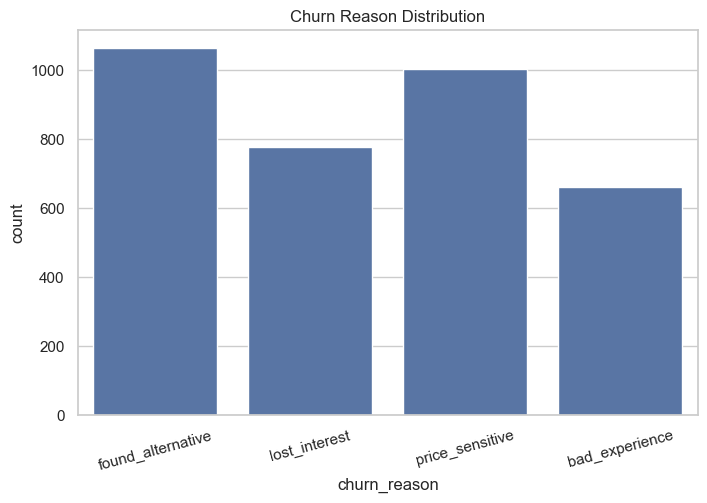

In [2]:
#Target Variable Distribution(Class imbalance)
plt.figure(figsize=(8,5))
sns.countplot(x="churn_reason", data=df)
plt.title("Churn Reason Distribution")
plt.xticks(rotation=15)
plt.show()

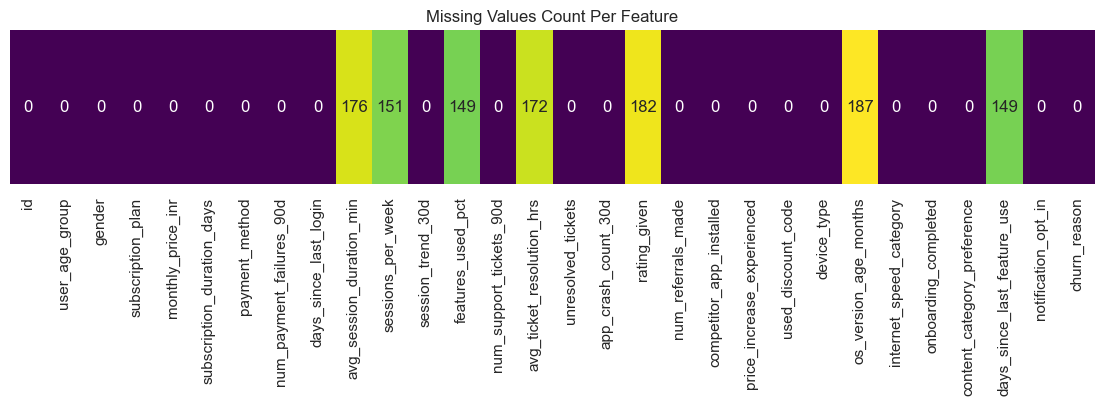

In [3]:
#Missing Values Via Heatmap
missing_counts = df.isnull().sum().to_frame(name="missing_count").T

plt.figure(figsize=(14, 2))
sns.heatmap(
    missing_counts,
    annot=True,          
    fmt="d",              
    cmap="viridis",
    cbar=False
)
plt.title("Missing Values Count Per Feature")
plt.yticks([])
plt.show()

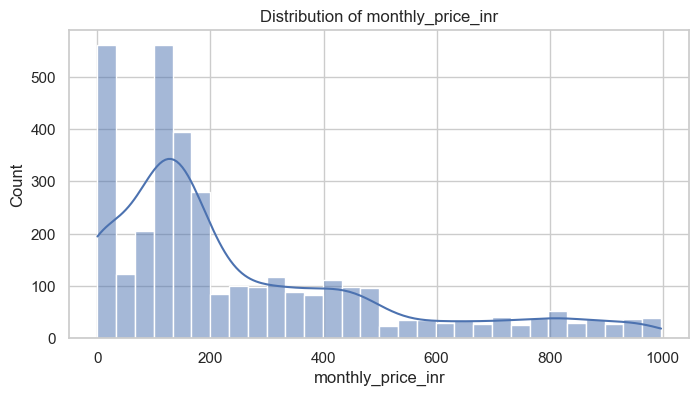

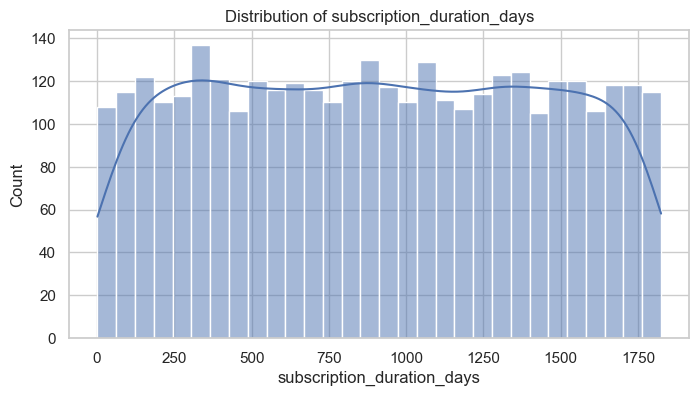

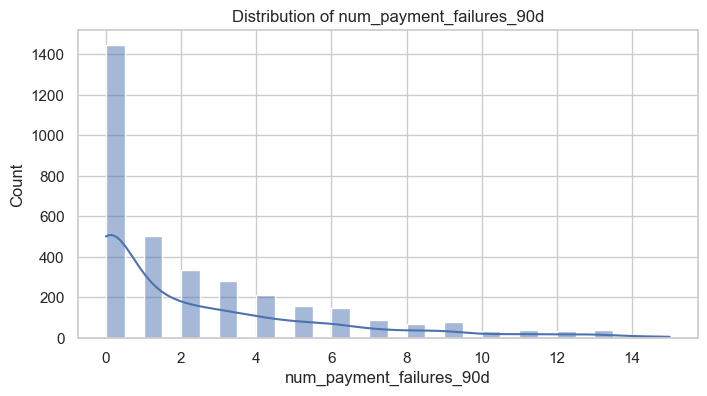

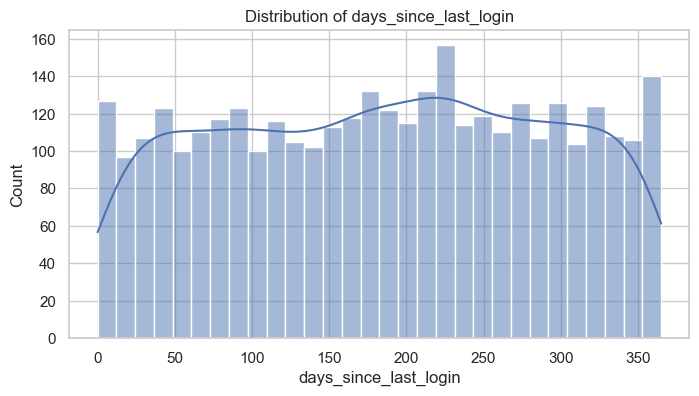

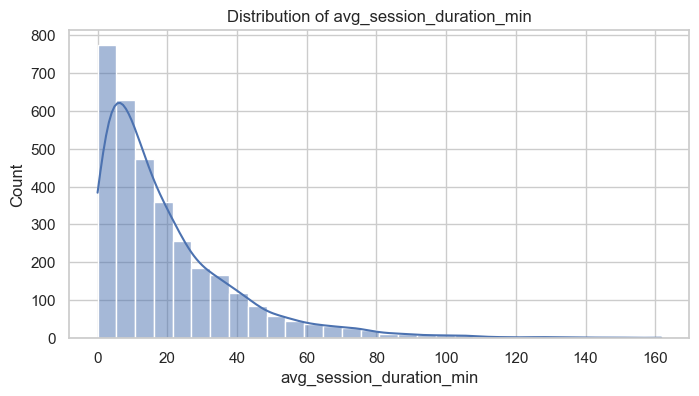

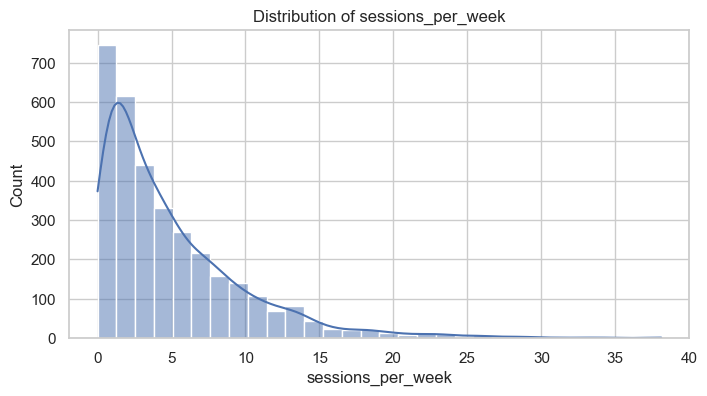

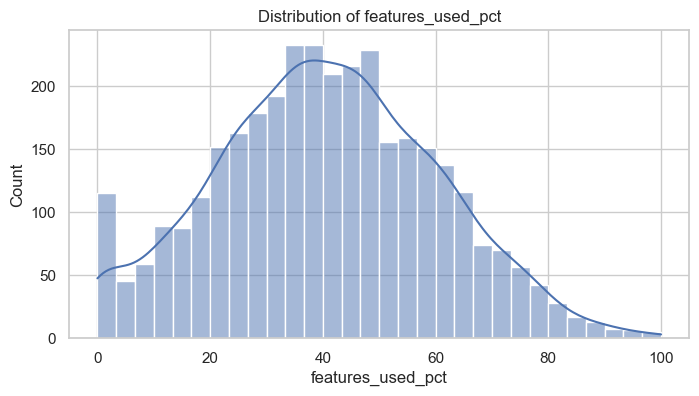

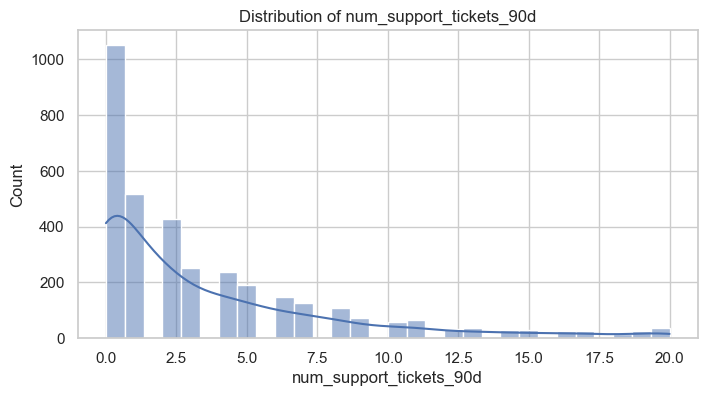

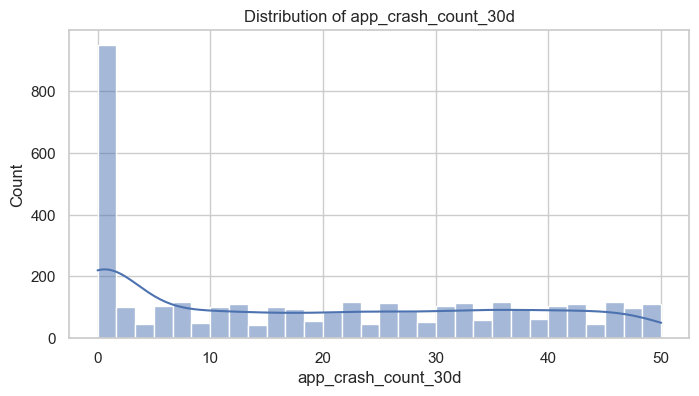

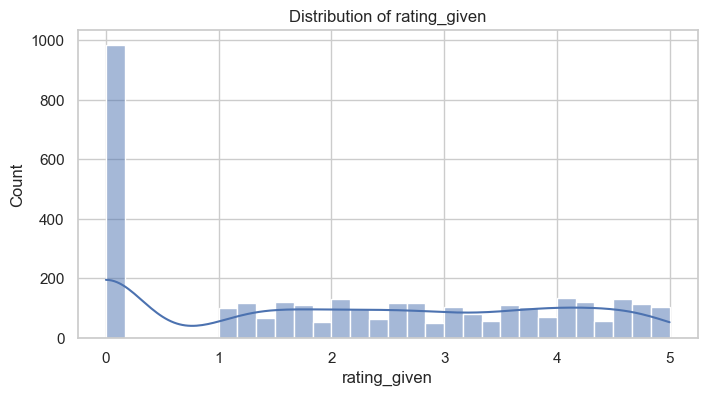

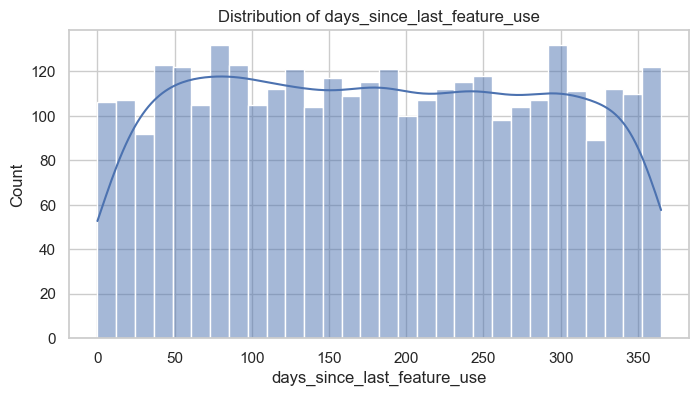

In [4]:
# Numerical Feature Distributions (Histogram + KDE)
num_cols = [
    "monthly_price_inr", "subscription_duration_days", "num_payment_failures_90d",
    "days_since_last_login", "avg_session_duration_min", "sessions_per_week",
    "features_used_pct", "num_support_tickets_90d", "app_crash_count_30d",
    "rating_given", "days_since_last_feature_use"
]

for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

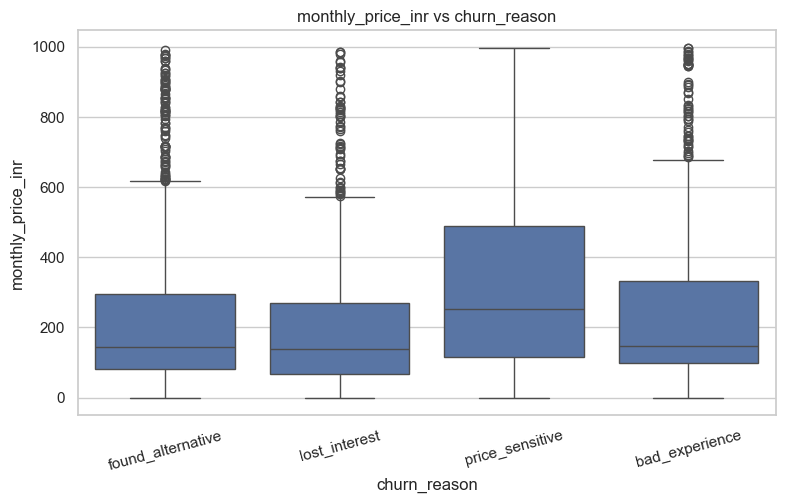

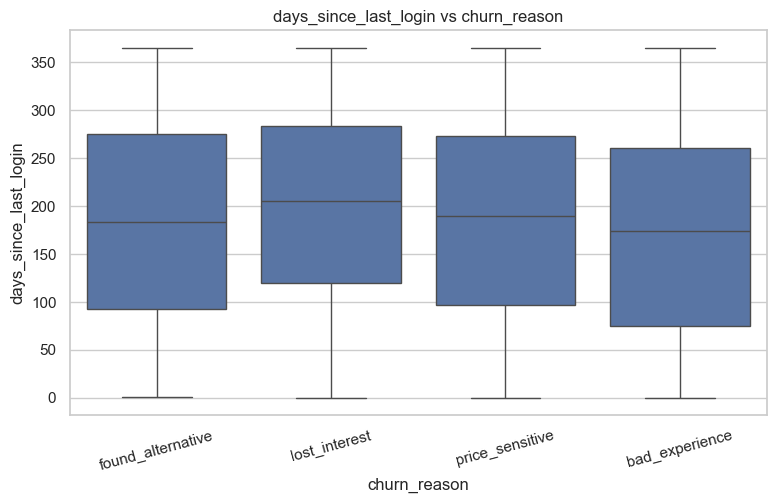

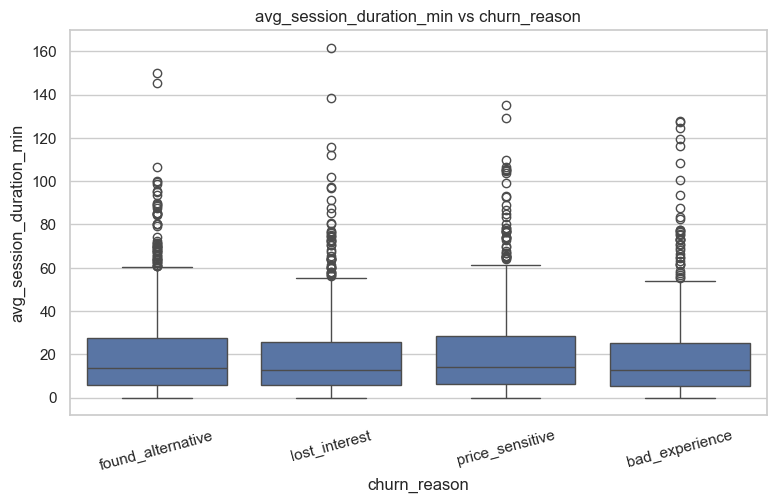

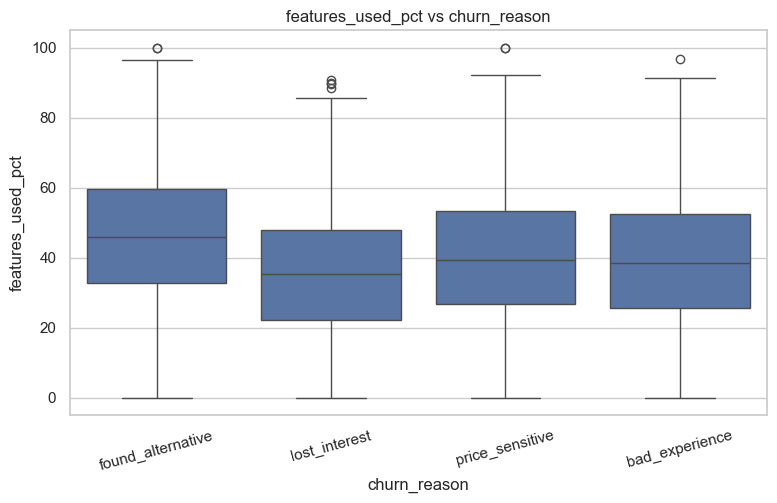

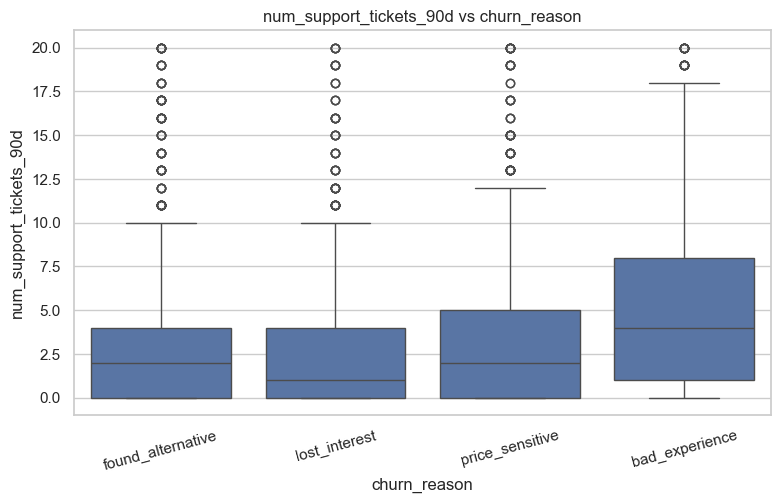

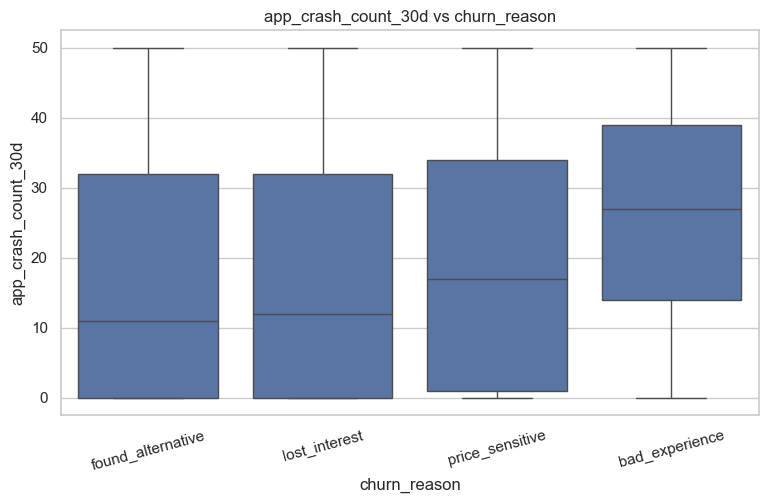

In [5]:
# Feature vs Target (Boxplots for Numerical Features)
important_num = [
    "monthly_price_inr",
    "days_since_last_login",
    "avg_session_duration_min",
    "features_used_pct",
    "num_support_tickets_90d",
    "app_crash_count_30d"
]

for col in important_num:
    plt.figure(figsize=(9,5))
    sns.boxplot(x="churn_reason", y=col, data=df)
    plt.title(f"{col} vs churn_reason")
    plt.xticks(rotation=15)
    plt.show()

<Figure size 1000x500 with 0 Axes>

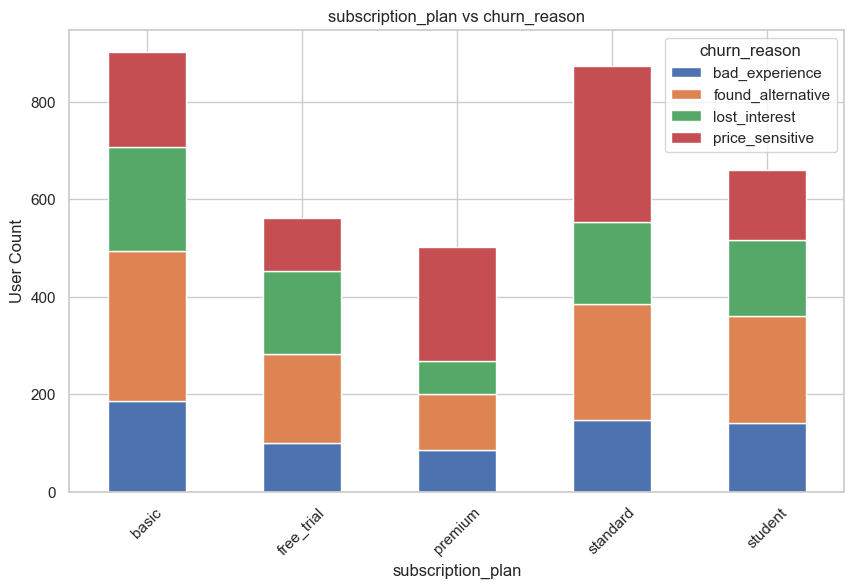

<Figure size 1000x500 with 0 Axes>

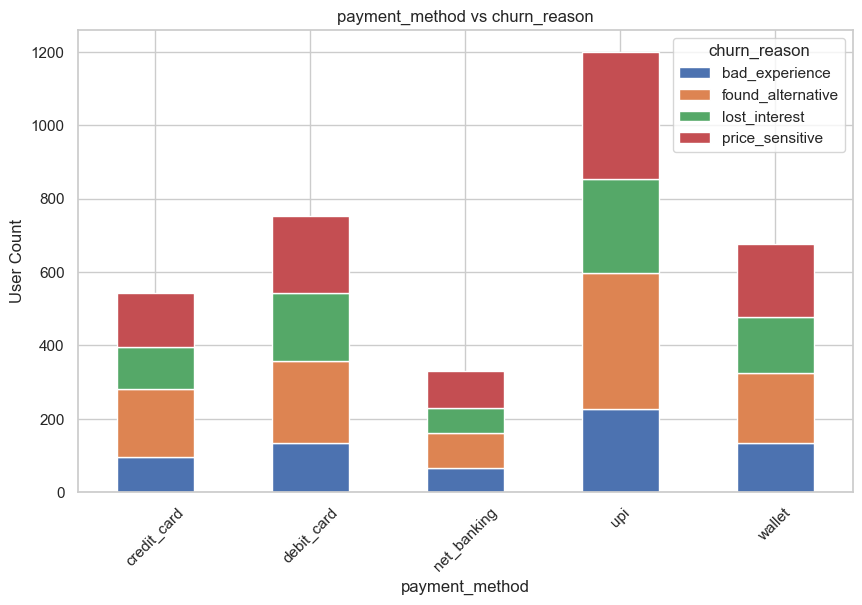

<Figure size 1000x500 with 0 Axes>

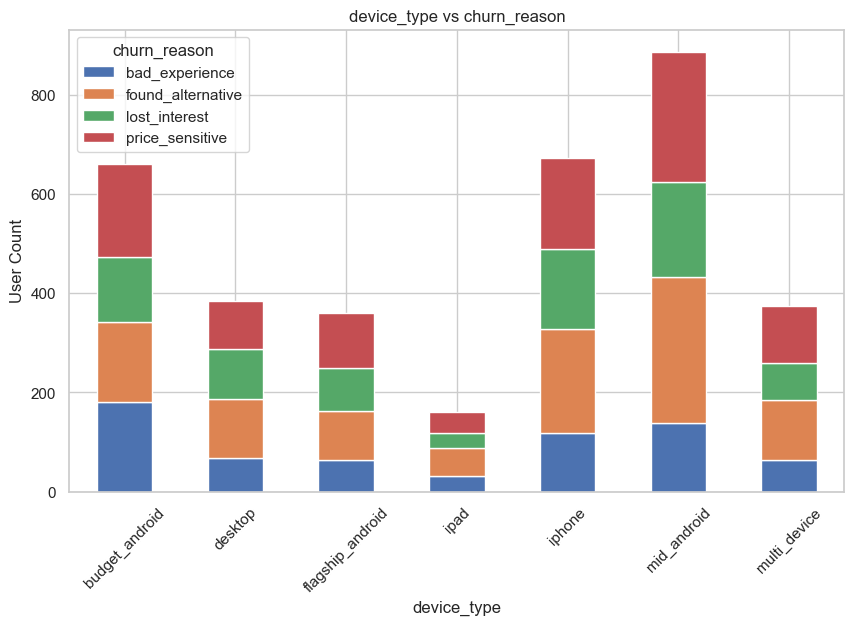

<Figure size 1000x500 with 0 Axes>

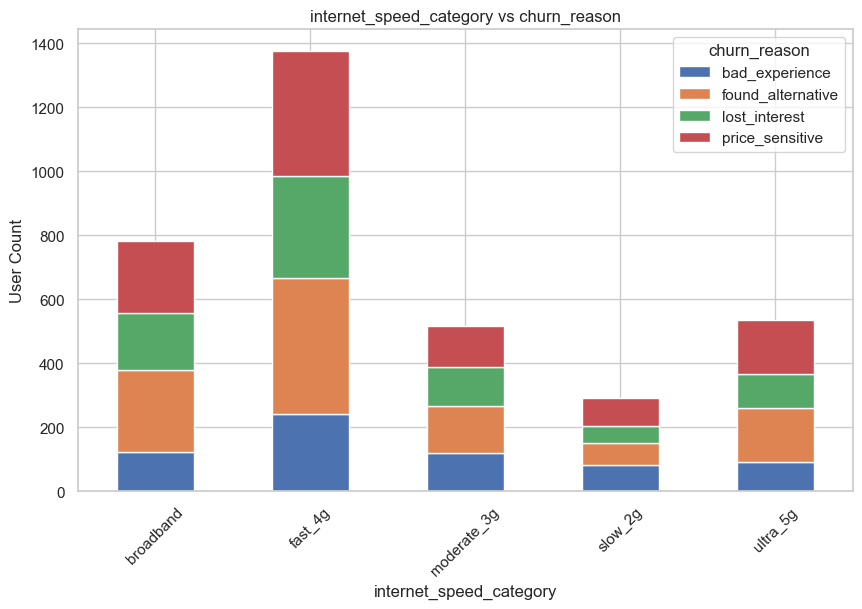

<Figure size 1000x500 with 0 Axes>

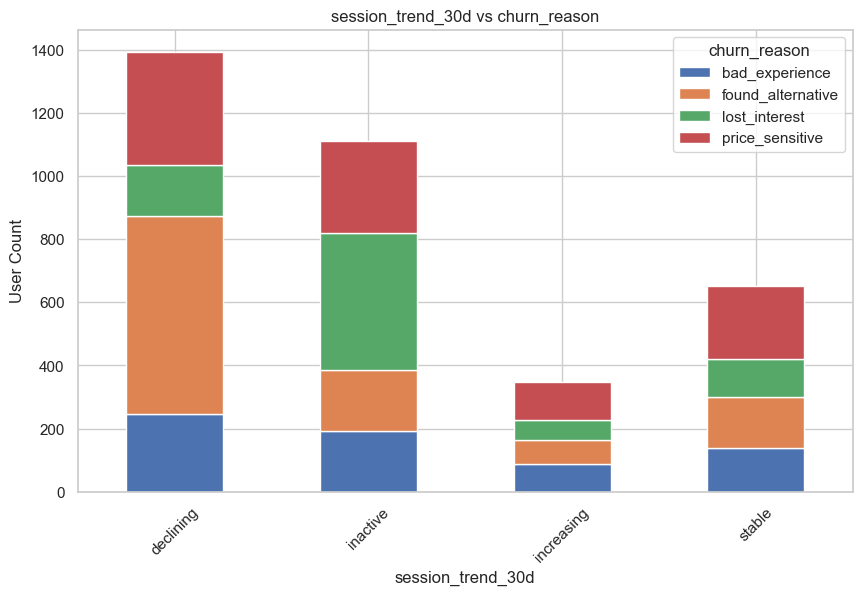

<Figure size 1000x500 with 0 Axes>

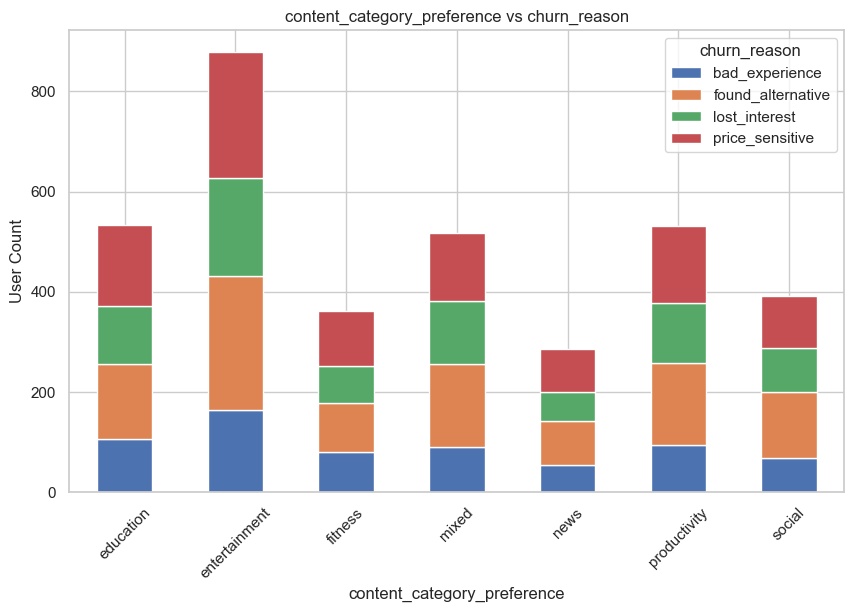

In [6]:
# Categorical Features vs Target (Stacked Bar Charts)
cat_cols = [
    "subscription_plan", "payment_method", "device_type",
    "internet_speed_category", "session_trend_30d",
    "content_category_preference"
]

for col in cat_cols:
    plt.figure(figsize=(10,5))
    prop_df = (
        df.groupby([col, "churn_reason"])
          .size()
          .unstack()
          .fillna(0)
    )
    prop_df.plot(kind="bar", stacked=True)
    plt.title(f"{col} vs churn_reason")
    plt.ylabel("User Count")
    plt.xticks(rotation=45)
    plt.show()

<Figure size 700x400 with 0 Axes>

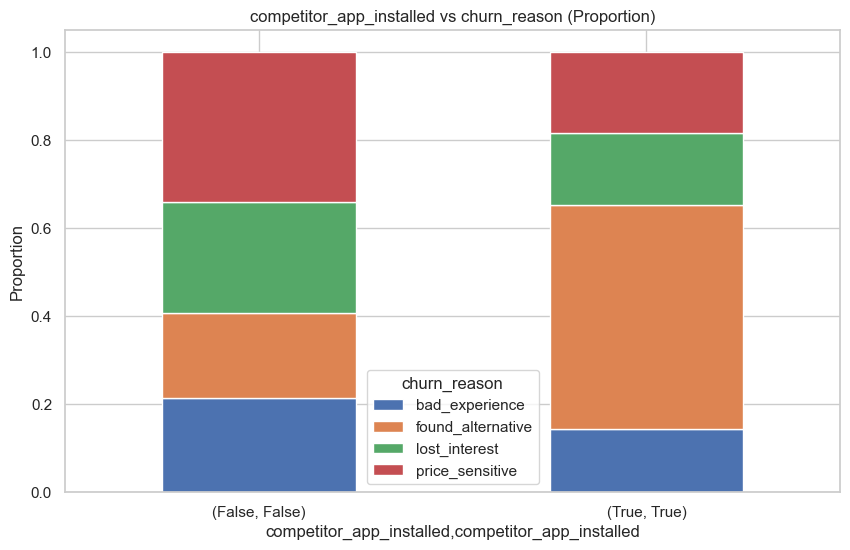

<Figure size 700x400 with 0 Axes>

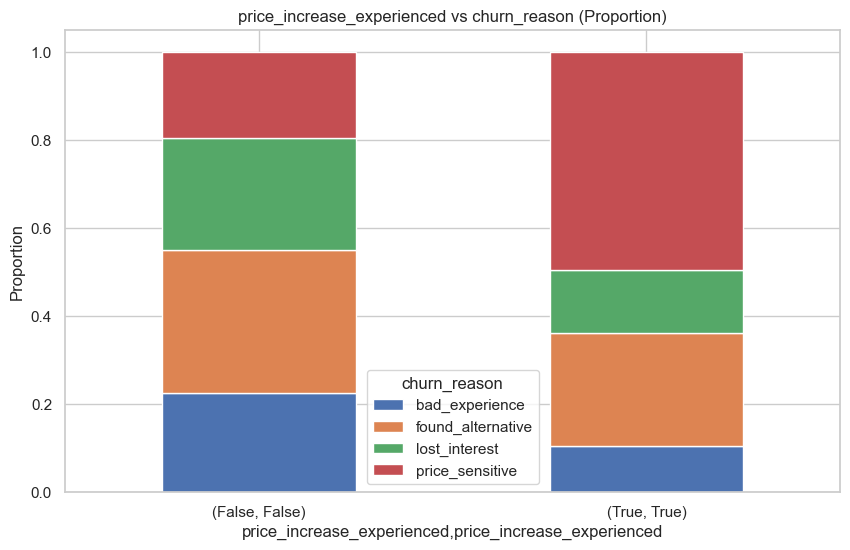

<Figure size 700x400 with 0 Axes>

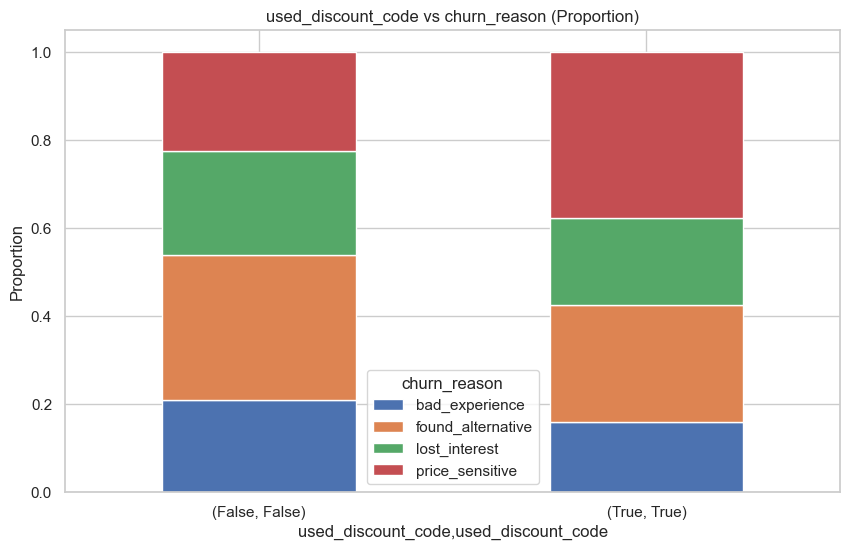

<Figure size 700x400 with 0 Axes>

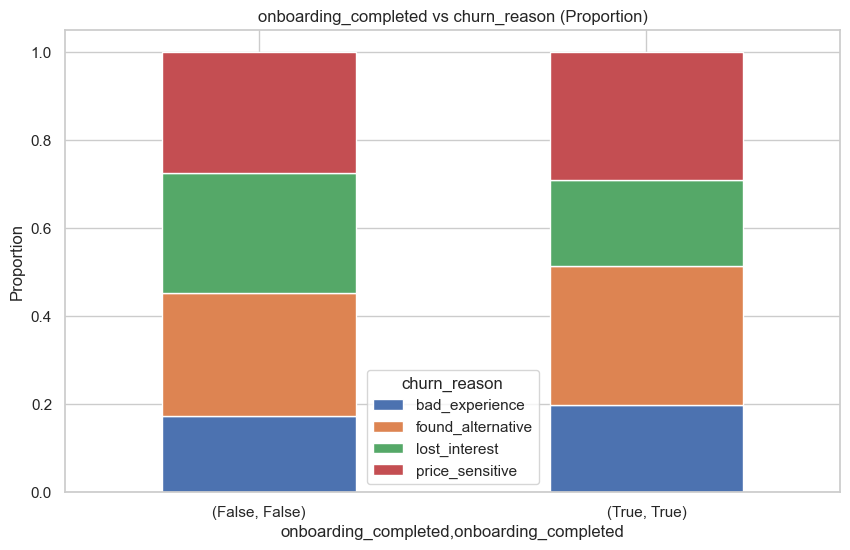

<Figure size 700x400 with 0 Axes>

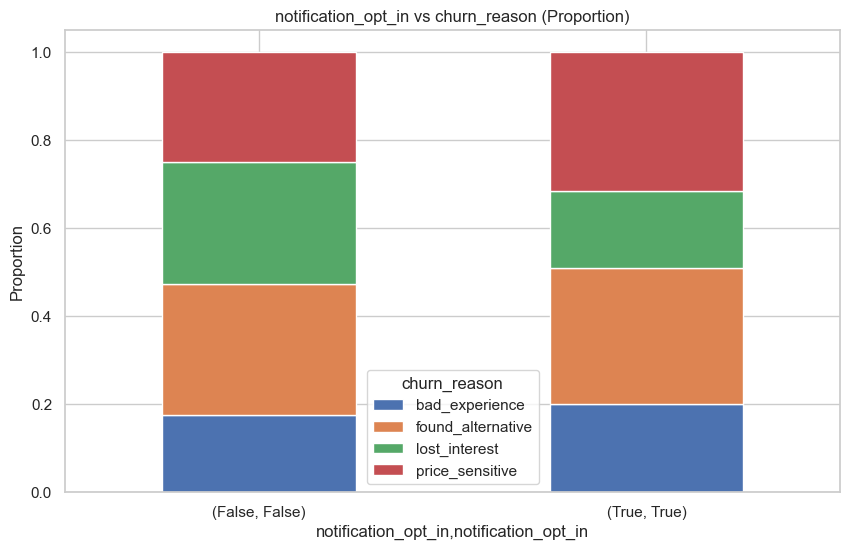

In [7]:
# Boolean Features vs Target (Percentage View)
bool_cols = [
    "competitor_app_installed", "price_increase_experienced",
    "used_discount_code", "onboarding_completed", "notification_opt_in"
]

for col in bool_cols:
    plt.figure(figsize=(7,4))
    prop_df = (
        df.groupby([col, "churn_reason"])
          .size()
          .groupby(level=0)
          .apply(lambda x: x / x.sum())
          .unstack()
    )
    prop_df.plot(kind="bar", stacked=True)
    plt.title(f"{col} vs churn_reason (Proportion)")
    plt.ylabel("Proportion")
    plt.xticks(rotation=0)
    plt.show()

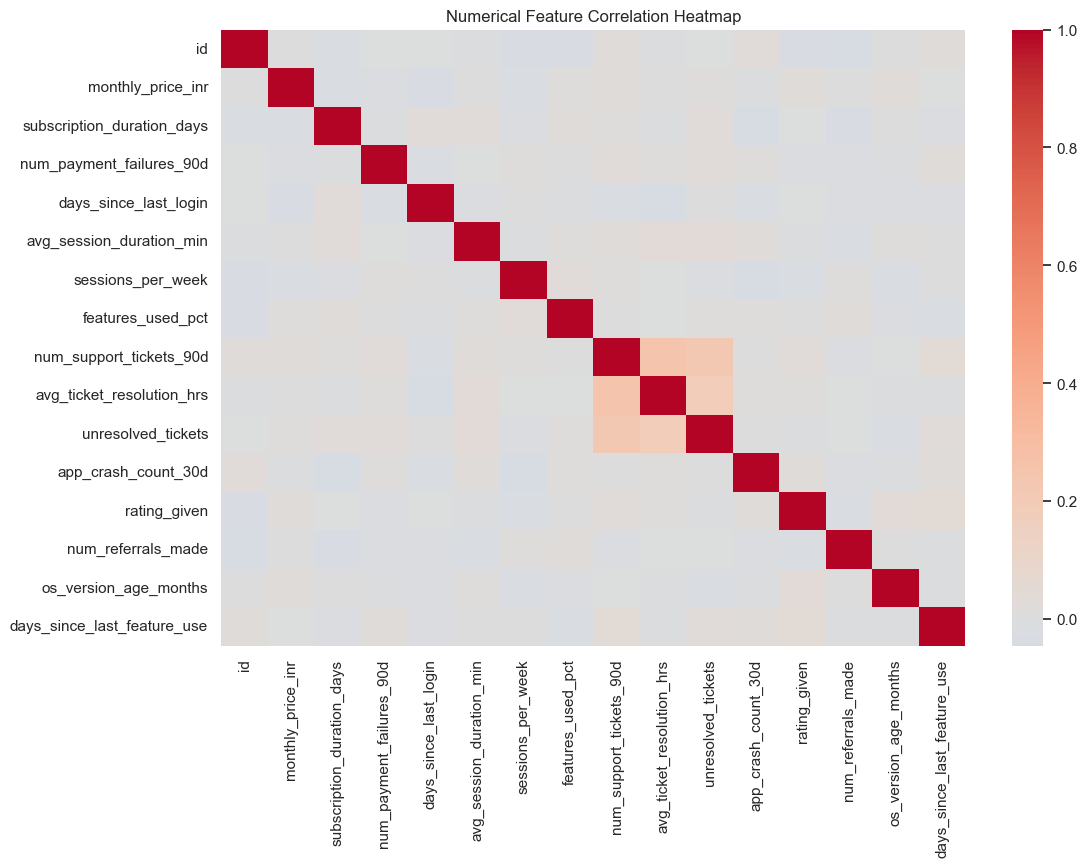

In [8]:
# Correlation Heatmap (Numerical Features)
num_df = df.select_dtypes(include=["int64", "float64"])

plt.figure(figsize=(12,8))
sns.heatmap(num_df.corr(), cmap="coolwarm", center=0)
plt.title("Numerical Feature Correlation Heatmap")
plt.show()

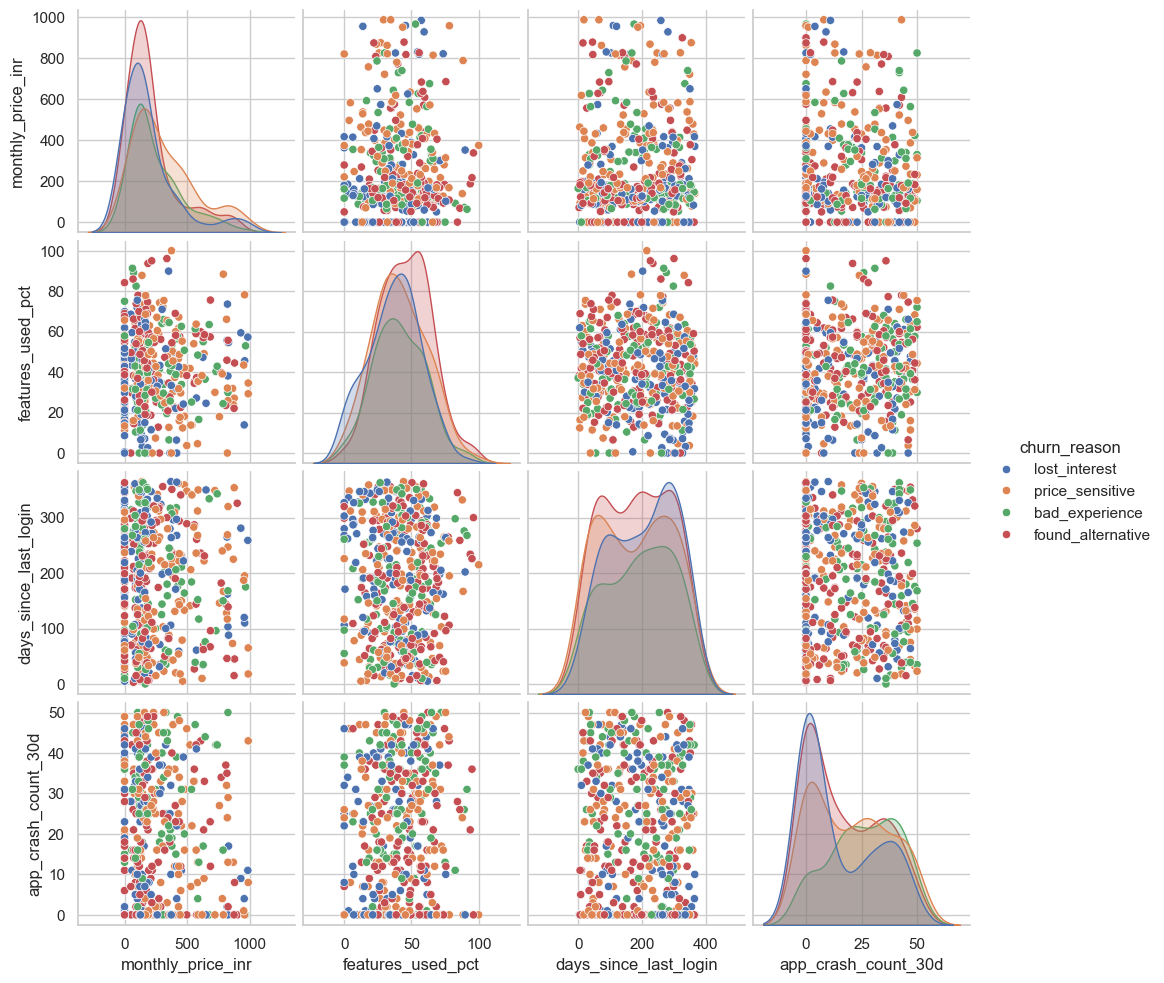

In [9]:
# Pairwise Relationship for Key Features (Optional but powerful)
sample_df = df.sample(500, random_state=42)  # smaller sample for speed

sns.pairplot(
    sample_df,
    vars=["monthly_price_inr", "features_used_pct", "days_since_last_login", "app_crash_count_30d"],
    hue="churn_reason"
)
plt.show()

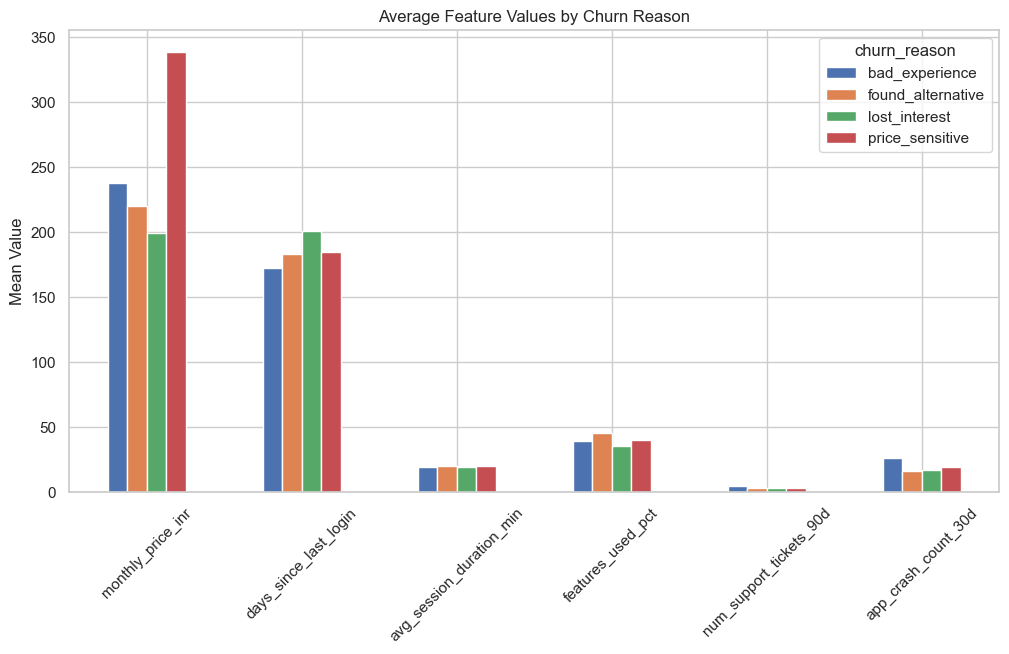

In [10]:
# Churn Reason Profiles (Mean Feature Values per Class)
profile = df.groupby("churn_reason")[important_num].mean()

profile.T.plot(kind="bar", figsize=(12,6))
plt.title("Average Feature Values by Churn Reason")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.show()

In [11]:
#!pip install catboost
#!pip install xgboost==1.7.6

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier



In [22]:
# ─── 1. LOAD DATA ────────────────────────────────────────────────────────────
print("Loading data...")
train = pd.read_csv(r"C:\Users\Devil\Desktop\Coding\Spec2Model\train_B.csv")
test  = pd.read_csv(r"C:\Users\Devil\Desktop\Coding\Spec2Model\test_B.csv")

print(f"Train shape: {train.shape}")
print(f"Test shape:  {test.shape}")
print(f"\nClass distribution:\n{train['churn_reason'].value_counts()}")
print(f"\nMissing values in train:\n{train.isnull().sum()[train.isnull().sum()>0]}")

# If train and test are the same file (common mistake), create a holdout test split
if train.equals(test):
    print("Warning: train and test are identical — creating a test split from train (80/20).")
    from sklearn.model_selection import train_test_split
    if 'churn_reason' in train.columns:
        train, test = train_test_split(train, test_size=0.2, stratify=train['churn_reason'], random_state=42)
    else:
        train, test = train_test_split(train, test_size=0.2, random_state=42)
    print(f"After split — Train shape: {train.shape}, Test shape: {test.shape}")

Loading data...
Train shape: (3500, 30)
Test shape:  (600, 29)

Class distribution:
churn_reason
found_alternative    1062
price_sensitive      1001
lost_interest         776
bad_experience        661
Name: count, dtype: int64

Missing values in train:
avg_session_duration_min       176
sessions_per_week              151
features_used_pct              149
avg_ticket_resolution_hrs      172
rating_given                   182
os_version_age_months          187
days_since_last_feature_use    149
dtype: int64


In [23]:
# ─── 2. FEATURE ENGINEERING ──────────────────────────────────────────────────

def engineer_features(df):
    df = df.copy()

    # --- Price sensitivity signals ---
    df['price_pain'] = (
        df['num_payment_failures_90d'].fillna(0) * 2 +
        df['price_increase_experienced'].astype(int) * 3 +
        df['used_discount_code'].astype(int) * 1
    )

    # --- Bad experience signals ---
    df['experience_pain'] = (
        df['app_crash_count_30d'].fillna(0) * 2 +
        df['num_support_tickets_90d'].fillna(0) * 1.5 +
        df['unresolved_tickets'].fillna(0) * 3 +
        (df['avg_ticket_resolution_hrs'].fillna(0) / 24).clip(0, 10)
    )
    # Low rating + crashes = bad experience
    df['low_rating_crashes'] = (df['rating_given'] < 2.5).astype(int) * df['app_crash_count_30d'].fillna(0)

    # --- Found alternative signals ---
    df['alt_signal'] = (
        df['competitor_app_installed'].astype(int) * 3 +
        (df['session_trend_30d'] == 'declining').astype(int) * 2 +
        df['num_referrals_made'].fillna(0)  # engaged users switch intentionally
    )

    # --- Lost interest signals ---
    df['disengagement_score'] = (
        df['days_since_last_login'].fillna(0) / 30 +
        df['days_since_last_feature_use'].fillna(0) / 30 +
        (1 - df['notification_opt_in'].astype(int)) * 2 +
        (df['session_trend_30d'] == 'inactive').astype(int) * 3 +
        (df['sessions_per_week'].fillna(0) < 1).astype(int) * 2
    )

    # --- Engagement quality ---
    df['engagement_score'] = (
        df['sessions_per_week'].fillna(0) * 
        df['avg_session_duration_min'].fillna(0) / 100
    )
    df['feature_engagement'] = df['features_used_pct'].fillna(0) / 100

    # --- Subscription value ---
    df['days_per_inr'] = df['subscription_duration_days'] / (df['monthly_price_inr'] + 1)
    df['is_free'] = (df['monthly_price_inr'] == 0).astype(int)
    df['is_long_subscriber'] = (df['subscription_duration_days'] > 365).astype(int)

    # --- Device & connectivity quality ---
    device_quality = {
        'budget_android': 1, 'mid_android': 2, 'flagship_android': 4,
        'iphone': 5, 'ipad': 4, 'desktop': 3, 'multi_device': 5
    }
    df['device_quality_score'] = df['device_type'].map(device_quality).fillna(2)

    net_quality = {
        'slow_2g': 1, 'moderate_3g': 2, 'fast_4g': 4,
        'ultra_5g': 5, 'broadband': 5
    }
    df['net_quality_score'] = df['internet_speed_category'].map(net_quality).fillna(2)
    df['poor_experience_context'] = (df['device_quality_score'] <= 2) & (df['net_quality_score'] <= 2)
    df['poor_experience_context'] = df['poor_experience_context'].astype(int)

    # --- Interactions ---
    df['crash_on_budget'] = df['app_crash_count_30d'].fillna(0) * (df['device_quality_score'] <= 2).astype(int)
    df['price_increase_failure'] = df['price_increase_experienced'].astype(int) * df['num_payment_failures_90d'].fillna(0)
    df['competitor_declining'] = df['competitor_app_installed'].astype(int) * (df['session_trend_30d'] == 'declining').astype(int)
    df['high_usage_then_gone'] = (df['sessions_per_week'].fillna(0) > 5).astype(int) * (df['days_since_last_login'].fillna(0) > 30).astype(int)

    # --- Onboarding ---
    df['onboarding_completed'] = df['onboarding_completed'].astype(int)

    #Noisy Data Solution
    df['experience_pain'] = df['experience_pain'].clip(0, 50)
    df['price_pain'] = df['price_pain'].clip(0, 30)
    df['disengagement_score'] = df['disengagement_score'].clip(0, 30)

    return df


In [24]:
def encode_features(df_train, df_test):
    """Encode categoricals consistently without test leakage."""
    df_train = df_train.copy()
    df_test = df_test.copy()

    cat_cols = [
        'user_age_group', 'gender', 'subscription_plan', 'payment_method',
        'session_trend_30d', 'device_type', 'internet_speed_category',
        'content_category_preference'
    ]
    bool_cols = [
        'competitor_app_installed', 'price_increase_experienced',
        'used_discount_code', 'notification_opt_in', 'onboarding_completed'
    ]

    # Booleans → int (handle missing columns and NaNs safely)
    for col in bool_cols:
        # train
        if col in df_train.columns:
            df_train[col] = df_train[col].fillna(0).astype(int)
        else:
            df_train[col] = 0
        # test
        if col in df_test.columns:
            df_test[col] = df_test[col].fillna(0).astype(int)
        else:
            df_test[col] = 0

    # Label encode categoricals (fit on train only)
    encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        df_train[col] = df_train[col].fillna('unknown').astype(str)
        df_test[col]  = df_test[col].fillna('unknown').astype(str)

        # fit on train only
        le.fit(df_train[col].values)
        df_train[col] = le.transform(df_train[col].values)

        # ensure an 'unknown' class exists for unseen labels in test
        if 'unknown' not in le.classes_:
            le.classes_ = np.append(le.classes_, 'unknown')

        # map unseen test labels to 'unknown' then transform
        known = set(le.classes_)
        df_test[col] = df_test[col].apply(lambda x: x if x in known else 'unknown')
        df_test[col] = le.transform(df_test[col].values)
        encoders[col] = le

    return df_train, df_test, encoders


In [25]:
# ─── 3. PREPROCESSING ────────────────────────────────────────────────────────

TARGET = 'churn_reason'
ID_COL = 'id'
label_map = {'price_sensitive': 0, 'bad_experience': 1, 'found_alternative': 2, 'lost_interest': 3}
label_inv = {v: k for k, v in label_map.items()}

# Map target and handle missing values in target
train[TARGET] = train[TARGET].map(label_map)
train = train.dropna(subset=[TARGET])
train[TARGET] = train[TARGET].astype(int)

# Engineer features
train = engineer_features(train)
test  = engineer_features(test)

# Encode categoricals
train, test, encoders = encode_features(train, test)

# Drop target from test if it exists
if TARGET in test.columns:
    test = test.drop(columns=[TARGET])

# Fill remaining nulls
num_cols = [c for c in train.select_dtypes(include=[np.number]).columns if c != TARGET]
for col in num_cols:
    if col in test.columns:
        median_val = train[col].median()
        train[col] = train[col].fillna(median_val)
        test[col]  = test[col].fillna(median_val)

# Define features (exclude ID and TARGET)
FEATURE_COLS = [c for c in train.columns if c not in [ID_COL, TARGET] and c in test.columns]

# Extract X, y, X_test
X = train[FEATURE_COLS].values
y = train[TARGET].values
X_test = test[FEATURE_COLS].values
test_ids = test[ID_COL].values

print(f"\nFeature count: {len(FEATURE_COLS)}")
print(f"Class distribution after encode: {np.bincount(y)}")


Feature count: 45
Class distribution after encode: [1001  661 1062  776]


In [26]:
# ─── 4. CLASS WEIGHTS ────────────────────────────────────────────────────────

classes = np.unique(y)
class_weights = compute_class_weight('balanced', classes=classes, y=y)
cw_dict = dict(zip(classes, class_weights))
print(f"\nClass weights: {cw_dict}")


Class weights: {np.int64(0): np.float64(0.8741258741258742), np.int64(1): np.float64(1.3237518910741302), np.int64(2): np.float64(0.8239171374764596), np.int64(3): np.float64(1.1275773195876289)}


In [27]:
# ─── 5. MODELS ───────────────────────────────────────────────────────────────

# LightGBM
lgb_params = dict(
    objective='multiclass',
    num_class=4,
    metric='multi_logloss',
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=63,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    class_weight='balanced',
    random_state=42,
    verbose=-1,
    n_jobs=-1,
)

# XGBoost
xgb_params = dict(
    objective='multi:softprob',
    num_class=4,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
)

# CatBoost
cat_params = dict(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    auto_class_weights='Balanced',
    loss_function='MultiClass',
    eval_metric='TotalF1',
    random_seed=42,
    verbose=0,
)

In [28]:
# ─── 6. OOF + TEST PREDICTIONS (Stacking) ───────────────────────────────────

N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof_lgb  = np.zeros((len(X), 4))
oof_xgb  = np.zeros((len(X), 4))
oof_cat  = np.zeros((len(X), 4))

test_lgb = np.zeros((len(X_test), 4))
test_xgb = np.zeros((len(X_test), 4))
test_cat = np.zeros((len(X_test), 4))

fold_scores = {'lgb': [], 'xgb': [], 'cat': []}

print("\n" + "="*60)
print("Running 5-Fold CV with LGB + XGB + CatBoost")
print("="*60)

for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
    X_tr, X_val = X[tr_idx], X[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]

    print(f"\n--- Fold {fold+1}/{N_FOLDS} ---")

    # LightGBM
    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(X_tr, y_tr)
    oof_lgb[val_idx]  = lgb_model.predict_proba(X_val)
    test_lgb         += lgb_model.predict_proba(X_test) / N_FOLDS
    score = f1_score(y_val, oof_lgb[val_idx].argmax(1), average='macro')
    fold_scores['lgb'].append(score)
    print(f"  LGB  F1: {score:.4f}")

    # XGBoost
    xgb_model = xgb.XGBClassifier(**xgb_params)
    xgb_model.fit(X_tr, y_tr)
    oof_xgb[val_idx]  = xgb_model.predict_proba(X_val)
    test_xgb         += xgb_model.predict_proba(X_test) / N_FOLDS
    score = f1_score(y_val, oof_xgb[val_idx].argmax(1), average='macro')
    fold_scores['xgb'].append(score)
    print(f"  XGB  F1: {score:.4f}")

    # CatBoost
    cat_model = CatBoostClassifier(**cat_params)
    cat_model.fit(
        X_tr, y_tr,
        eval_set=(X_val, y_val),
        early_stopping_rounds=50
    )
    oof_cat[val_idx]  = cat_model.predict_proba(X_val)
    test_cat         += cat_model.predict_proba(X_test) / N_FOLDS
    score = f1_score(y_val, oof_cat[val_idx].argmax(1), average='macro')
    fold_scores['cat'].append(score)
    print(f"  CAT  F1: {score:.4f}")

print("\n" + "="*60)
print("OOF Scores Summary:")
for name, scores in fold_scores.items():
    print(f"  {name.upper():4s}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


Running 5-Fold CV with LGB + XGB + CatBoost

--- Fold 1/5 ---
  LGB  F1: 0.5544
  XGB  F1: 0.5729
  CAT  F1: 0.6107

--- Fold 2/5 ---
  LGB  F1: 0.5362
  XGB  F1: 0.5600
  CAT  F1: 0.5534

--- Fold 3/5 ---
  LGB  F1: 0.5344
  XGB  F1: 0.5369
  CAT  F1: 0.5185

--- Fold 4/5 ---
  LGB  F1: 0.5639
  XGB  F1: 0.5601
  CAT  F1: 0.5927

--- Fold 5/5 ---
  LGB  F1: 0.5765
  XGB  F1: 0.5876
  CAT  F1: 0.5801

OOF Scores Summary:
  LGB : 0.5531 ± 0.0161
  XGB : 0.5635 ± 0.0168
  CAT : 0.5711 ± 0.0322


In [29]:
# ─── 7. ENSEMBLE ─────────────────────────────────────────────────────────────

# Simple weighted average (tune weights based on OOF scores)
lgb_mean = np.mean(fold_scores['lgb'])
xgb_mean = np.mean(fold_scores['xgb'])
cat_mean  = np.mean(fold_scores['cat'])
total     = lgb_mean + xgb_mean + cat_mean

w_lgb = lgb_mean / total
w_xgb = xgb_mean / total
w_cat = cat_mean  / total

print(f"\nEnsemble weights — LGB: {w_lgb:.3f}  XGB: {w_xgb:.3f}  CAT: {w_cat:.3f}")

# OOF ensemble
oof_ensemble = w_lgb * oof_lgb + w_xgb * oof_xgb + w_cat * oof_cat
oof_preds    = oof_ensemble.argmax(1)

oof_f1 = f1_score(y, oof_preds, average='macro')
print(f"\nEnsemble OOF Macro F1: {oof_f1:.4f}")
print("\nClassification Report (OOF):")
print(classification_report(y, oof_preds, target_names=list(label_map.keys())))
print("Confusion Matrix (OOF):")
print(confusion_matrix(y, oof_preds))

# Test ensemble
test_ensemble = w_lgb * test_lgb + w_xgb * test_xgb + w_cat * test_cat
test_preds    = test_ensemble.argmax(1)


Ensemble weights — LGB: 0.328  XGB: 0.334  CAT: 0.338

Ensemble OOF Macro F1: 0.5664

Classification Report (OOF):
                   precision    recall  f1-score   support

  price_sensitive       0.60      0.63      0.61      1001
   bad_experience       0.53      0.49      0.51       661
found_alternative       0.63      0.65      0.64      1062
    lost_interest       0.52      0.48      0.50       776

         accuracy                           0.58      3500
        macro avg       0.57      0.57      0.57      3500
     weighted avg       0.58      0.58      0.58      3500

Confusion Matrix (OOF):
[[630  94 159 118]
 [113 327 104 117]
 [166  88 694 114]
 [141 108 152 375]]


In [30]:
# ─── 8. FEATURE IMPORTANCE ───────────────────────────────────────────────────

# Use last fold's LGB model for importance
importance_df = pd.DataFrame({
    'feature': FEATURE_COLS,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Features (LightGBM):")
print(importance_df.head(20).to_string(index=False))


Top 20 Features (LightGBM):
                    feature  importance
          features_used_pct        2686
 subscription_duration_days        2487
      days_since_last_login        2478
days_since_last_feature_use        2454
        disengagement_score        2394
           engagement_score        2350
   avg_session_duration_min        2318
          monthly_price_inr        2256
      os_version_age_months        2209
          sessions_per_week        2189
               days_per_inr        2176
  avg_ticket_resolution_hrs        2048
               rating_given        1776
        app_crash_count_30d        1640
            experience_pain        1257
                 price_pain        1256
         feature_engagement        1164
    num_support_tickets_90d        1109
                 alt_signal         989
                device_type         981


In [31]:
# ─── 9. GENERATE SUBMISSION ──────────────────────────────────────────────────

predictions_str = [label_inv[p] for p in test_preds]

submission = pd.DataFrame({
    'id': test_ids,
    'prediction': predictions_str
})

submission.to_csv("predictions.csv", index=False)
print(f"\nSubmission saved: predictions.csv ({len(submission)} rows)")
print(f"Value counts:\n{submission['prediction'].value_counts()}")

# Validate format
assert set(submission['prediction'].unique()).issubset(set(label_map.keys())), "Invalid label!"
assert submission['id'].nunique() == len(submission), "Duplicate IDs!"
assert submission.isnull().sum().sum() == 0, "Missing values!"
print("\n✓ Submission format validated successfully!")


Submission saved: predictions.csv (600 rows)
Value counts:
prediction
found_alternative    191
price_sensitive      188
lost_interest        123
bad_experience        98
Name: count, dtype: int64

✓ Submission format validated successfully!
